# Assignment 01 - Dog Breed

Identifying dog breeds using the [Stanford Dogs Dataset](https://www.kaggle.com/competitions/dog-breed-identification/overview)

Thiago Amado Costa


In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm 
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
import tensorflow as tf
from keras.applications import VGG16
from keras.layers import Dense, Flatten, Dropout, GlobalAvgPool2D
from keras.optimizers import Adam
from keras import Model
from cv2 import imread, resize, IMREAD_GRAYSCALE

## Reading Dataset

- labels.csv is composed of the name of the image (id) and its corresponding class
- only for the train images

In [142]:
df = pd.read_csv('dogs/labels.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


## Train - SVM

- converting images to grayscale
- creating X (pixels) and y (breeds)

In [143]:
breeds = sorted(list(set(df['breed']))) # sorted list of unique values of y (breeds)
num_breeds = dict(zip(breeds, range(len(breeds)))) # assign each breed a number 0..120

def convert_img(id):
    img = imread(f'dogs/train/{id}.jpg')
    img = resize(img, (128, 128))
    return img

def create_values_and_labels():
    y = []
    X = []
    for row in df.to_numpy():
        converted_img = convert_img(row[0])
        y.append(num_breeds[row[1]])
        X.append(converted_img)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

X,y = create_values_and_labels()

In [144]:
X = X / 255

- plotting a dog as example

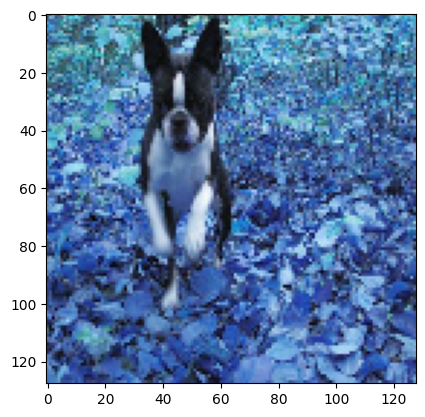

In [110]:
# plt.imshow(X[0].reshape(128,128), cmap='grey')
plt.imshow(X[0], cmap='grey')

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
i = 5000

In [153]:
model = svm.SVC(random_state=42, kernel='linear')
model.fit(X_train[:i], y_train[:i])
s1 = model.score(X_test, y_test)
print(f'SVM linear accuracy: {s1}')
model = svm.SVC(random_state=42, kernel='poly')
model.fit(X_train[:i], y_train[:i])
s2 = model.score(X_test.values, y_test.values)
print(f'SVM poly accuracy: {s2}')
pipe = Pipeline([('normalizer', Normalizer()), ('svc', svm.SVC(kernel='poly'))])
# joblib.dump(pipe, 'models/pipe.joblib')
pipe.fit(X_train, y_train)
s3 = pipe.score(X_test, y_test)
print(f'Pipeline accuracy: {s3}')

## Training - CNN

In [150]:
base = VGG16(include_top=False, input_shape=(128,128,3), weights='imagenet')

_x = base.output
_x = Flatten()(_x)
_x = Dense(512, activation='relu')(_x)
_x = Dense(128, activation='relu')(_x)
predictions = Dense(120, activation='softmax')(_x)
cnn = Model(inputs=base.input, outputs=predictions)


for layer in cnn.layers[:11]:
    layer.trainable = False

cnn.compile(optimizer=Adam(0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Epoch 1/10
64/64 [==============================] - 432s 7s/step - loss: 4.7918 - accuracy: 0.0099 - val_loss: 4.7493 - val_accuracy: 0.0191
Epoch 2/10
64/64 [==============================] - 408s 6s/step - loss: 4.6936 - accuracy: 0.0247 - val_loss: 4.5821 - val_accuracy: 0.0357
Epoch 3/10
64/64 [==============================] - 407s 6s/step - loss: 4.3721 - accuracy: 0.0637 - val_loss: 4.1961 - val_accuracy: 0.0812
Epoch 4/10
64/64 [==============================] - 409s 6s/step - loss: 3.7111 - accuracy: 0.1575 - val_loss: 3.6402 - val_accuracy: 0.1584
Epoch 5/10
64/64 [==============================] - 407s 6s/step - loss: 2.9251 - accuracy: 0.2854 - val_loss: 3.2792 - val_accuracy: 0.2269
Epoch 6/10
64/64 [==============================] - 407s 6s/step - loss: 2.1614 - accuracy: 0.4359 - val_loss: 3.2063 - val_accuracy: 0.2396
Epoch 7/10
64/64 [==============================] - 407s 6s/step - loss: 1.4363 - accuracy: 0.6060 - val_loss: 3.2723 - val_accuracy: 0.2748
Epoch 8/10
64

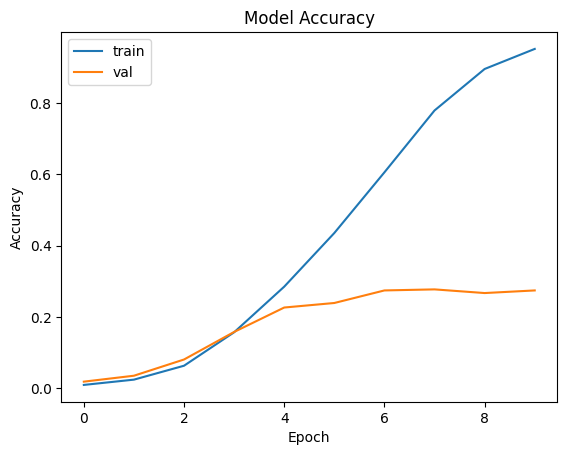

In [151]:
history = cnn.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()